# Birth-death process

The birth-death process in a heterogeneous population of interacting cells contains the following reaction network in each individual cell,

$$
\xrightarrow{C^b_i} \mathrm{P}_i \xrightarrow{C^d_i}\\
\mathrm{P}_i \xrightarrow{c^t} \mathrm{Q} \\
\mathrm{Q} \xrightarrow{c^t} \mathrm{P}_i ,
$$

for $i=1, \ldots, N$. The birth and death reaction rate constants are independent random variables as indicated by capital letters $C^b_i$ and $C^d_i$, while the transport rate $c^t$ is fixed.

## Symmetry-reduced moment dynamics
This system can be described with a symmetry-reduced model of up to the second order using $\hat{K}_{eq}=12$ differential equations regardless of the population size. The system is non-closed due to the extrinsic noise of the birth and death reaction rate constants. To solve for the moment dynamics, we used a gaussian moment-closure approximation (MA). We solved for moment dynamics at different population sizes $N=[5, 10, 50]$ and transport rates $c^t = [0, 0.01, 0.1]$.

In [1]:
# Import required modules.
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from birthdeath_functions import * 

# Number of cells in the popuation.
N_list = [5, 10, 50]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Solve moments for different N and kt.
u_stack = np.zeros(12)
labels = np.zeros(2)
for N in N_list:
    for k in k_list:
        # P, Ss.
        i_mean = np.array([20, 0]) 
        i_std = np.array([5, 0])
        # kb, kd, kout, kin.
        k_mean = np.array([1, 0.01, k, k])
        k_std = np.array([0.1, 0.001, 0, 0])
        u = solve_moments(N, i_mean, i_std, k_mean, k_std)
        u_stack = np.vstack((u_stack,u['y'].transpose()))    
        labels = np.vstack((labels,np.array([N,k])))
u_stack = u_stack[1:,:]
labels = labels[1:,:]

# Reformat into Pandas Dataframe.
u_df = pd.DataFrame(u_stack, columns=['P0','Ss','P0**2',
                                      'P0*Ss','P0*P1','P0*kb0',
                                      'P0*kd0','P0*kb1','P0*kd1',
                                      'Ss**2','Ss*kb0','Ss*kd0'])
u_df.index = np.tile(u['t'],len(N_list)*len(k_list))
u_df['Time'] = np.tile(u['t'],len(N_list)*len(k_list))
u_df['N'] = np.repeat(N_list, len(k_list)*len(u['t']))
u_df['k'] = np.tile(np.repeat(k_list, len(u['t'])), len(N_list))
u_df['Std(P0)'] = ((u_df['P0**2']-u_df['P0']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(P0)'] = u_df['Std(P0)']/u_df['P0']
u_df['Var(P0-P1)'] = (2*u_df['P0**2']-2*u_df['P0*P1'])
u_df['Var(P0)'] = u_df['P0**2']-u_df['P0']**2

# Save moment results.
u_df.to_csv('birthdeath_moments.csv', sep = ';')

## Stochastic simulations
We compared the approximated moment dynamics with moments calculated from exact SSA runs for the same sets of $N$ and $c^t$. 95% confidence intervals were calculated by bootstrapping the SSA results.

In [2]:
# Import required modules.
import pandas as pd
import numpy as np
from birthdeath_functions import * 

# Number of cells in the popuation.
N_list = [5, 10, 50]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Run SSAs and compile into dataframe.
runs = 200 # We used 1000 for our results. It just takes longer to finish.
s_df = pd.DataFrame()
for N in N_list: # Different population sizes.
    s_stack_df = runSSA(N, 0.1, runs, 0.1)
    s_df = s_df.append(s_stack_df, sort='True')
s2_df = pd.DataFrame()
for k in [0, 0.01]: # Different signalling molecule transport rates.
    s2_stack_df = runSSA(10, k, runs, 0.1)
    s2_df = s2_df.append(s2_stack_df, sort='True')
s3_df = pd.concat([s_df,s2_df], sort = False, axis = 0)

# Bootstrap results.
pts = 100
bs_set = pd.DataFrame(columns={'lower','upper','N','k','typ'})
for N in N_list:
    for k in k_list:
        sub_s = s3_df[(s3_df['N']==N) & (s3_df['k']==k)]
        if np.shape(sub_s)[0] != 0:
            sub_s.insert(55, '(P0-P1)^2', (sub_s['P0']-sub_s['P1'])**2)
            a = bootstrapping(sub_s, 'mean', runs, pts, ['P0'])
            b = bootstrapping(sub_s, 'var', runs, pts, ['P0'])
            c = bootstrapping(sub_s, 'cv', runs, pts, ['P0'])
            d = bootstrapping(sub_s, 'pv', runs, pts, ['(P0-P1)^2','P0','P1'])
            bootstrap = pd.concat((a,b,c,d), sort=False)
            bootstrap['N'] = np.repeat(N, np.shape(bootstrap)[0])
            bootstrap['k'] = np.repeat(k, np.shape(bootstrap)[0])
            bootstrap['typ'] = np.repeat(['mean','var','cv','pv'], np.shape(bootstrap)[0]/4)
            bs_set = pd.concat((bs_set, bootstrap), sort=False)

# Save results.
s3_df.to_csv('birthdeath_ssa.csv', sep = ';')
bs_set.to_csv('birthdeath_bs.csv', sep = ';')

## Plot results
This section recreates Figure 2 in the paper from the saved results.

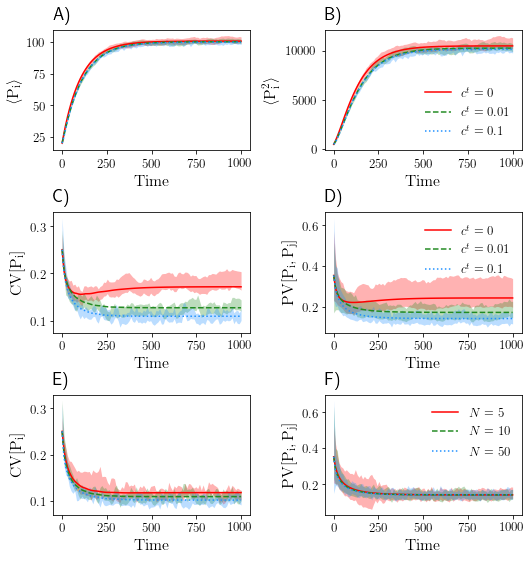

In [3]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Open saved results.
u_df = pd.read_csv('birthdeath_moments.csv', sep = ';', index_col=0 )
bs_set = pd.read_csv('birthdeath_bs.csv', sep = ';', index_col=0)

# Number of cells in the popuation.
N_list = [5, 10, 50]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Set figure format.
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['axes.titlepad'] = 10

plt.figure(figsize=(7.5,7.9))
bg_color = ['red', 'forestgreen', 'dodgerblue']
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Plot results.
plt.subplot(3,2,1)
N = 10
s = 'P0'
linestyles = ['-','--',':']
for idx,k in enumerate(k_list):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='mean')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], linewidth=0, alpha =0.3)
    plt.plot(sub_u['Time'], sub_u[s], color = bg_color[idx], linestyle = linestyles[idx], linewidth = 1.5, label = '$c^t = '+ str(k) + '$')
plt.xlabel('$\mathrm{Time}$')
plt.ylabel(r'$\langle \mathrm{P_i}\rangle$')
plt.title('A)', loc = 'left')

plt.subplot(3,2,2)
N = 10
s = 'P0**2'
for idx,k in enumerate(k_list):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='var')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], sub_u[s], color = bg_color[idx], linestyle = linestyles[idx], linewidth = 1.5, label = '$c^t = '+str(k)+'$')    
plt.xlabel('$\mathrm{Time}$')
plt.ylabel(r'$\langle\mathrm{P_i^2}\rangle$')
plt.title('B)', loc = 'left')
plt.legend(loc = 'lower right', frameon = False)

plt.subplot(3,2,3)
for idx, k in enumerate(k_list):
    sub_u = u_df[(u_df['N']==10) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='cv')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], sub_u['CV(P0)'], color = bg_color[idx], linestyle = linestyles[idx], label = '$c^t = '+ str(k) + '$')
plt.ylabel('$\mathrm{CV[P_i]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('C)', loc = 'left')

plt.subplot(3,2,4)
for idx, k in enumerate(k_list):
    sub_u = u_df[(u_df['N']==10) & (u_df['k']==k)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='pv')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], (sub_u['Var(P0-P1)']/(sub_u['P0']**2))**0.5, color = bg_color[idx], linestyle = linestyles[idx], label = '$c^t = '+ str(k) + '$')
plt.ylabel('$\mathrm{PV[P_i,P_j]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('D)', loc = 'left')
plt.legend(loc = 'upper right', frameon = False)

plt.subplot(3,2,5)
for idx, N in enumerate(N_list):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==0.1)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='cv')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], sub_u['CV(P0)'], color = bg_color[idx], linestyle = linestyles[idx], label = '$N = '+ str(N) + '$')
plt.ylabel('$\mathrm{CV[P_i]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('E)', loc = 'left')

plt.subplot(3,2,6)
for idx, N in enumerate(N_list):
    sub_u = u_df[(u_df['N']==N) & (u_df['k']==0.1)]
    ci = bs_set[(bs_set['N']==N) & (bs_set['k']==k) & (bs_set['typ']=='pv')]
    plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[idx], zorder = 0, label = '_nolegend_', alpha =0.3, linewidth=0)
    plt.plot(sub_u['Time'], (sub_u['Var(P0-P1)']/(sub_u['P0']**2))**0.5, color = bg_color[idx], linestyle = linestyles[idx], label = '$N = '+ str(N) + '$')
plt.ylabel('$\mathrm{PV[P_i,P_j]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('F)', loc='left')
plt.legend(loc = 'upper right', frameon = False)
plt.tight_layout(h_pad=-0.05)

# Save and display plot.
plt.savefig('birthdeath.pdf', pad_inches=0)
plt.show()

## Extrinsic noise
Next we look at the effect of varying extrinsic noise of the birth reaction rate parameter to $CV[P_i]$ and $PV[P_i,P_j]$. We follow the same process of solving for moment dynamics with the reduced model at different noise levels of $C^b_i$ from $CV[C^b_i] = [0, 0.05, 0.1]$ and $c^t = [0, 0.01, 0.1]$. These moments are then compared with moments calculated from SSA runs.

This section solves moment dynamics from the same reduced set of equations.

In [4]:
# Import required modules.
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from birthdeath_functions import * 

# Number of cells in the popuation.
N = 10

# Variability (stdev) of birth reaction rate parameter.
std_list = [0, 0.05, 0.1]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Solve moments for different N and kt.
u_stack = np.zeros(12)
labels = np.zeros(2)
for std in std_list:
    for k in k_list:
        # P, Ss.
        i_mean = np.array([20, 0]) 
        i_std = np.array([5, 0])
        # kb, kd, kout, kin.
        k_mean = np.array([1, 0.01, k, k])
        k_std = np.array([std, 0.001, 0, 0])
        u = solve_moments(N, i_mean, i_std, k_mean, k_std)
        u_stack = np.vstack((u_stack,u['y'].transpose()))    
        labels = np.vstack((labels,np.array([k,std])))
u_stack = u_stack[1:,:]
labels = labels[1:,:]

# Reformat into Pandas Dataframe.
u_df = pd.DataFrame(u_stack, columns=['P0','Ss','P0**2',
                                      'P0*Ss','P0*P1','P0*kb0',
                                      'P0*kd0','P0*kb1','P0*kd1',
                                      'Ss**2','Ss*kb0','Ss*kd0'])
u_df.index = np.tile(u['t'],len(k_list)*len(std_list))
u_df['Time'] = np.tile(u['t'],len(k_list)*len(std_list))
u_df['k'] = np.tile(np.repeat(k_list, len(u['t'])),len(std_list))
u_df['std'] = np.repeat(std_list, len(k_list)*len(u['t']))
u_df['Std(P0)'] = ((u_df['P0**2']-u_df['P0']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(P0)'] = u_df['Std(P0)']/u_df['P0']
u_df['Var(P0-P1)'] = (2*u_df['P0**2']-2*u_df['P0*P1'])
u_df['Var(P0)'] = u_df['P0**2']-u_df['P0']**2

# Save moment results.
u_df.to_csv('birthdeath_ex_moments.csv', sep = ';')

This section runs SSA for the same parameter sets.

In [5]:
# Import required modules.
import pandas as pd
import numpy as np
from sympy import symbols
from birthdeath_functions import * 

# Number of cells in the popuation.
N = 10

# Variability (stdev) of birth reaction rate parameter.
std_list = [0, 0.05, 0.1]

# Transport of signalling molecule.
k_list = [0, 0.01, 0.1]

# Run SSAs and compile into dataframe.
runs = 200 # We used 1000 for our results. It just takes longer to finish.
s_df = pd.DataFrame()
for k in k_list:
    for std in std_list:
        s_stack_df = runSSA(N, k, runs, std)
        s_df = s_df.append(s_stack_df, sort='True')

# Bootstrap results.
cv_df = pd.DataFrame(columns = ['k','std','lower','upper','ave'])
pts = 100
label = ['P0']
for k in k_list:
    for std in std_list:
        data = s_df[(s_df['k']==k) & (s_df['std']==std)]
        ave = data.groupby('time').std().iloc[-1][label[0]]/data.groupby('time').mean().iloc[-1][label[0]]
        ci = bootstrapping(data, 'cv', runs, pts, label)
        cv_df = pd.concat([cv_df, pd.DataFrame({'k':[k],'std':[std],'lower':[ci['lower'][pts-1]],
                                               'upper':[ci['upper'][pts-1]],'ave':[ave]})], sort='False')
        
pv_df = pd.DataFrame(columns = ['k','std','upper','lower','ave'])
label = ['(P0-P1)^2','P0','P1']
for k in k_list:
    for std in std_list:
        data = s_df[(s_df['k']==k) & (s_df['std']==std)]
        data.insert(15, '(P0-P1)^2', (data['P0']-data['P1'])**2)
        d1 = data.groupby('time').mean().iloc[-1][label[1]]
        d2 = data.groupby('time').mean().iloc[-1][label[2]]
        ave = (data.groupby('time').mean().iloc[-1][label[0]]/(d1*d2))**0.5
        ci = bootstrapping(data, 'pv', runs, pts, label)
        pv_df = pd.concat([pv_df,pd.DataFrame({'k':[k],'std':[std],'lower':[ci['lower'][pts-1]],
                                               'upper':[ci['upper'][pts-1]],'ave':[ave]})], sort='False')   

# Save results.
s_df.to_csv('birthdeath_ex_ssa.csv', sep = ';')
cv_df.to_csv('birthdeath_ex_cv.csv', sep = ';')
pv_df.to_csv('birthdeath_ex_pv.csv', sep = ';')

This section recreates Figure 3 in the paper from the saved results.

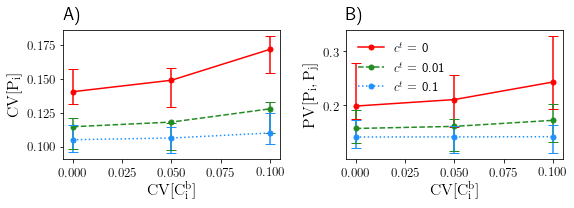

In [6]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Open saved results.
u_df = pd.read_csv('birthdeath_ex_moments.csv', sep = ';', index_col=0)
s_df = pd.read_csv('birthdeath_ex_ssa.csv', sep = ';', index_col=0)
cv_df = pd.read_csv('birthdeath_ex_cv.csv', sep = ';', index_col=0)
pv_df = pd.read_csv('birthdeath_ex_pv.csv', sep = ';', index_col=0)
endpt = u_df[(u_df.index==1000)] # Where we get 'steady-state' value

# Set figure format.
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['axes.titlepad'] = 10

plt.figure(figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Plot results.
plt.subplot(1,2,1)
styles = ['-','--',':']
markers = ['o','o','o']
bg_color = ['red', 'forestgreen', 'dodgerblue']
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_endpt = endpt[(endpt['k']==k)]
    x = np.array(sub_endpt['std'])
    y = np.array(sub_endpt['CV(P0)'])
    plt.plot(x, y, marker = markers[idx], label = '$c^t = $ '+str(k), 
             color = bg_color[idx], markersize = 5, ls = styles[idx])
    err_data = cv_df[(cv_df['k']==k)]
    plt.errorbar(x, np.array(err_data['ave']), yerr=[np.array(err_data['ave']-err_data['lower']), 
                                                     np.array(err_data['upper']-err_data['ave'])], 
                 ls = 'None', color = bg_color[idx], capsize = 5, label = '_nolegend_')
plt.xlabel('$\mathrm{CV[C^b_i]}$')
plt.ylabel('$\mathrm{CV[P_i]}$')
plt.title('A)', loc = 'left')


plt.subplot(1,2,2)
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_endpt = endpt[(endpt['k']==k)]
    x = np.array(sub_endpt['std'])
    y = np.array((sub_endpt['Var(P0-P1)']/(sub_endpt['P0']*sub_endpt['P0']))**0.5)
    plt.plot(x, y, marker = markers[idx], label = '$c^t$ = '+str(k), color = bg_color[idx], markersize = 5, ls = styles[idx])
    err_data = pv_df[(pv_df['k']==k)]
    plt.errorbar(x, np.array(err_data['ave']), yerr=[np.array(err_data['ave'])-np.array(err_data['lower']), 
                                                     np.array(err_data['upper'])-np.array(err_data['ave'])], 
                 ls = 'None', color = bg_color[idx], capsize = 5, label = '_nolegend_')
plt.xlabel('$\mathrm{CV[C^b_i]}$')
plt.ylabel('$\mathrm{PV[P_i,P_j]}$')
plt.title('B)', loc = 'left')
plt.legend(frameon = False, loc = 'upper left')

plt.tight_layout()
plt.savefig('birthdeath_ex.pdf', pad_inches=0)
plt.show()